In [ ]:
############################################
## This script will simulate data from known statistical distirbutions of multivarte normal distribution; then estimate GAN and sample from it
## Final edit: 2023 July 5pm
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [ ]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv==0.18.0 --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet
! pip install numpy==1.24.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver 

In [ ]:

########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function
import scipy
from scipy.stats import kde

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU
import torch

# For plot/visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For take down the log in the loss plot
from io import StringIO

# Import seaborn for making statistical graphics
import seaborn as sns

# Change color setting
sns.set_style('darkgrid')

In [ ]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

#Sample Size for Precision of Correlation in Multivarte Normal Random Variable --- by Mathemtical Theory

In [ ]:
## Calculate Sample size by math

def samp_size_corr_coef(alpha, beta, correlation):
    C = 0.5 * np.log( (1+correlation)/(1-correlation) )
    n = ((scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+ scipy.stats.norm.ppf(q=beta, loc=0, scale=1))/C)**2 +3
    return(n)


In [ ]:
samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3) #113


112.67809433031636

In [ ]:
# input the mu_vector and sigma_matrix
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
sigma_matrix

array([[1. , 0.3],
       [0.3, 1. ]])

In [ ]:
mu_vec = np.array([0,0])
mu_vec

array([0, 0])

In [ ]:
# Testing out the code working validity in the defination
dat = scipy.stats.multivariate_normal.rvs(size=10, mean=mu_vec, cov=sigma_matrix)
dat


array([[-0.93665003,  0.3463049 ],
       [-0.3523312 ,  1.50869786],
       [ 0.52233849,  1.41148079],
       [-1.49011162, -1.12986384],
       [-0.41165384,  0.45622653],
       [ 0.48234941, -0.65416244],
       [-1.33211611, -1.0871453 ],
       [-0.59681424,  0.73200218],
       [-1.25909255, -0.25540589],
       [-1.07451845,  1.27923581]])

In [ ]:
res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
res

PearsonRResult(statistic=0.41848560236656773, pvalue=0.2287397023800059)

In [ ]:
# p value can be extract by
res[1]

0.2287397023800059

#Sample Size for Precision of a Corelation of Multivariate Normal Random Variable --- by numerical simulation

In [ ]:

def corr_ci_samp_size(n, mu_vec, sigma_matrix):

    ## Generate random data from multivariate normal
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    ## Grab the p-value, and correlation
    pval = res[1]
    corr = res[0]
    ## Tag whether one result is stat significant or not
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # this p value give you the mena p value
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)




In [ ]:
corr_ci_samp_size(n=113, mu_vec=mu_vec, sigma_matrix=sigma_matrix)

,corr,pval,tag
0,0.304032,0.001061,1


In [ ]:

## Replicate above function number of simulation replicate times to get power

# parameter available
n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
mu_vec = np.array([0,0])
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(corr_ci_samp_size(n=n, mu_vec=mu_vec, sigma_matrix=sigma_matrix))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate power of each column in the array #axis means column power
sim_power = np.mean(sim_df, axis=0)
sim_power

  0%|          | 0/1000 [00:00<?, ?it/s]

corr    0.295674
pval    0.024394
tag     0.901000
dtype: float64

In [ ]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

sim_results

,runtime,correlation,pvalue,power
0,1.591202,0.295674,0.024394,0.901


#Sample size estimation by GAN simulation

In [ ]:
# Record the log to plot loss
import sys

path = 'logs.txt'
sys.stdout = open(path, 'w')

In [ ]:
## Function to train a GAN model to simulated correlation data (with parms: pop_n, pop_mu_vec, pop_sigma_matrix)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)

    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)

    ## Return the learned model
    out = [model, x_pd]

    return out


  0%|          | 0/3 [00:00<?, ?it/s]

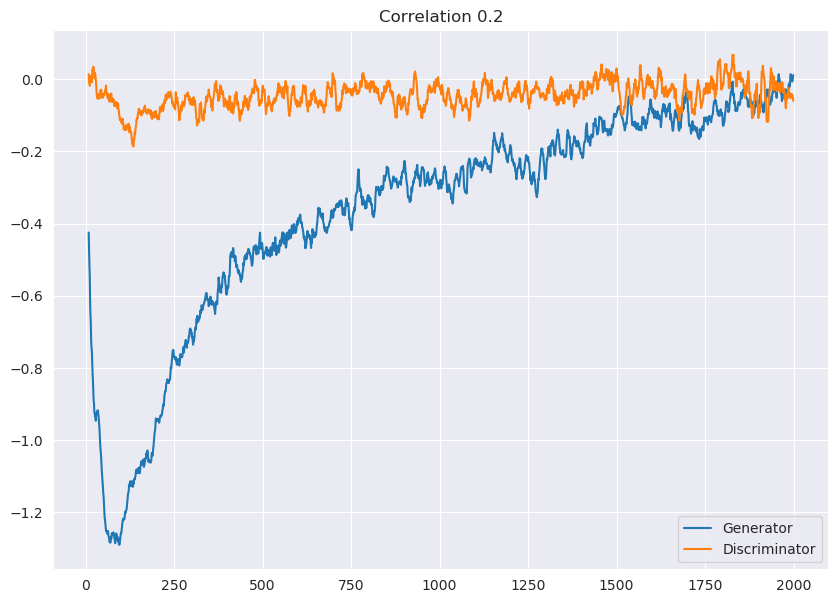

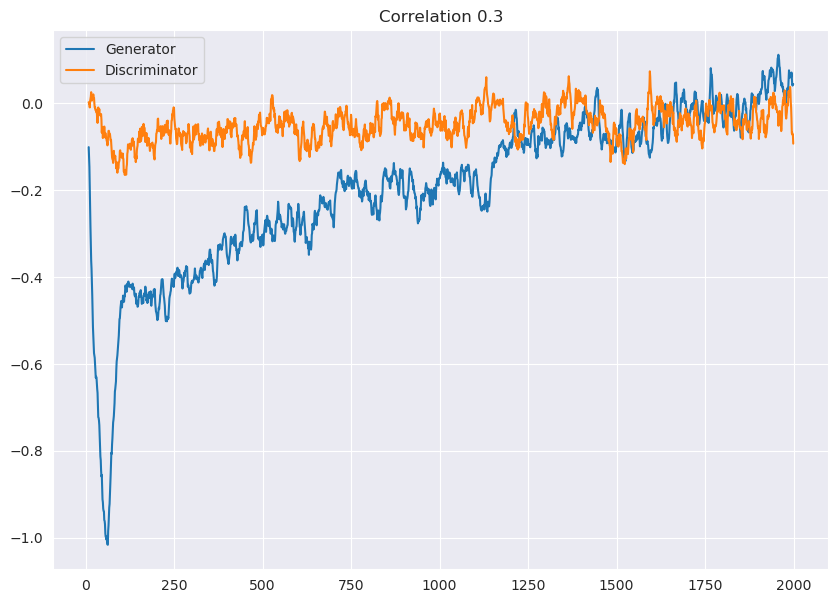

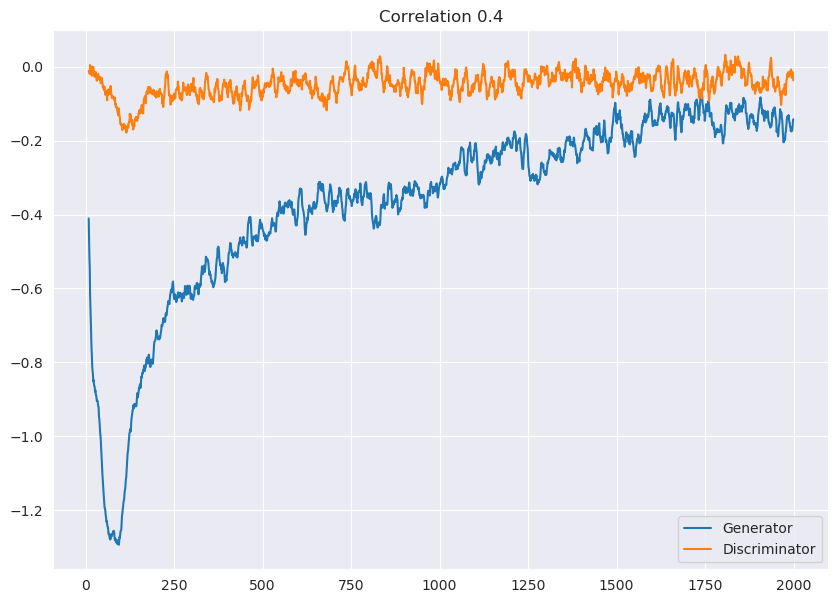

In [ ]:
correlations = [0.2, 0.3, 0.4]
models = {}

for correlation in tqdm(correlations):
    path = f'logs-{correlation}.txt'
    sys.stdout = open(path, 'w')

    pop_n = 10_000
    pop_mu_vec = np.array([0.0,0.0])
    pop_sigma_matrix = np.array([1.0, correlation, correlation, 1.0]).reshape((2,2))

    ## Get the learned GAN model --- after training
    t0 = time()
    train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)

    models[correlation] = train_gan[0]

    with open(f'logs-{correlation}.txt') as file:
        lines = file.readlines()

    output = "".join(lines)

    logs = StringIO(str(output))
    window = 10 # window size for the moving average, window=1 gets you the original series

    df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

    # I think a regex would be better here
    df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
    df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

    plt.figure(figsize=(10,7))

    # Plot with a moving average so it is less noisy
    plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
    plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

    plt.title(f'Correlation {correlation}')

    plt.legend()
    plt.show()

In [ ]:
models[0.2].sample(10)

,x0,x1
0,0.635794,-0.653763
1,0.424175,0.525731
2,1.368730,-0.556778
3,0.694169,0.680713
4,0.621049,0.819437
5,0.553477,-0.832909
6,-0.391070,-0.074469
7,-1.101115,0.577403
8,-1.302865,-0.483027
9,-0.219074,0.406664


In [ ]:
##################
#Alternative way of usiong magic comments
##################
 # %%time
# # %%capture output

# ## Parameters of binormal parent distribution
# pop_n = 50_000
# pop_mu_vec = np.array([0.0,0.0])
# pop_sigma_matrix = np.array([1.0, 0.3, 0.3, 1.0]).reshape((2,2))

# ## Get the learned GAN model --- after training
# t0 = time()
# train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
# t1 = time()
# fit_time = t1 - t0
# fit_time

# with open('logs.txt') as file:
#     lines = file.readlines()

# output = "".join(lines)
# logs = StringIO(str(output))
# window = 10 # window size for the moving average, window=1 gets you the original series

# df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# # I think a regex would be better here
# df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
# df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

# plt.figure(figsize=(10,7))

# # Plot with a moving average so it is less noisy
# plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
# plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

# plt.legend()
# plt.show()

In [ ]:
model_ = train_gan[0]

In [ ]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x0,x1
count,10000.000000,10000.000000
mean,0.004373,-0.012814
std,0.992755,0.993119
min,-3.201282,-4.197856
25%,-0.663871,-0.682686
50%,0.004348,-0.012543
75%,0.678899,0.659041
max,4.067625,3.479732


In [ ]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
sim_n

113

In [ ]:
## Function to analyze data from the sampled model
def corr_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)

    # Return the estimate and the CI to the user
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)


In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(corr_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean
gan_power = np.mean(gan_df, axis=0)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
gan_power

corr    0.413362
pval    0.001296
tag     0.996000
dtype: float64

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [gan_power[0]],
    'pvalue': [gan_power[1]],
    'power': [gan_power[2]]
})

gan_results



,runtime,correlation,pvalue,power
0,22.284066,0.413362,0.001296,0.996


#Estimating sample size for Power from Multivariate Normal distribution

In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05],
              'corr': [0.2, 0.3, 0.4],
              'beta': [0.05, 0.1, 0.2, 0.3]}

param_df = expand_grid(dictionary)
param_df

,alpha,corr,beta
0,0.05,0.2,0.05
1,0.05,0.2,0.10
2,0.05,0.2,0.20
3,0.05,0.2,0.30
4,0.05,0.3,0.05
5,0.05,0.3,0.10
6,0.05,0.3,0.20
7,0.05,0.3,0.30
8,0.05,0.4,0.05
9,0.05,0.4,0.10


#Sample Size for Correlation in Multivate Normal Distribution by Theory or Analytic Formula

In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_corr_coef(alpha=param_df.loc[i, 'alpha'],
                          correlation=param_df.loc[i, 'corr'],
                          beta=param_df.loc[i, 'beta'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','corr','beta','n_theory']
samp_size_theory_df

,alpha,corr,beta,n_theory
0,0.05,0.2,0.05,320.0
1,0.05,0.2,0.10,259.0
2,0.05,0.2,0.20,194.0
3,0.05,0.2,0.30,154.0
4,0.05,0.3,0.05,139.0
5,0.05,0.3,0.10,113.0
6,0.05,0.3,0.20,85.0
7,0.05,0.3,0.30,68.0
8,0.05,0.4,0.05,76.0
9,0.05,0.4,0.10,62.0


#Sample Size for Power by Simulation from Multivariate Normal Distribution

In [ ]:
def corr_power_samp_size(corr, n):

    ## Generate random data
    sigma_matrix = np.array([1,corr,corr,1]).reshape((2,2))
    mu_vec = np.array([0,0])
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data

    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)

    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'corr': [corr],
                        'pval': [pval],
                        'tag': [tag]})
    return(out)


In [ ]:
corr_power_samp_size(corr=0.3, n=113)

,corr,pval,tag
0,0.2473,0.008272,1


In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_sim( corr, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(corr_power_samp_size(corr=corr, n=n))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array
    sim_power = np.mean(sim_df, axis=0)

    ## Return expect width
    sim_result = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

    return sim_result


In [ ]:
corr_power_samp_size_sim( corr=0.3, n=113,n_rep= 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

,runtime,correlation,pvalue,power
0,1.570019,0.297923,0.023513,0.897


In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, corr n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_value = corr_power_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                          corr= samp_size_theory_df.loc[i, 'corr'],
                          n_rep=n_rep)
    ## Round to largest integer
    #value 0 give you elment change from data frame to numebr
    power_value_ = power_value['power'].values[0]
    #power_width_ = power_width.tag
    ## Append sample size to list
    samp_size_sim_list.append(power_value_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','corr','beta','n_theory','power_width_sim']
samp_size_sim_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_sim
0,0.05,0.2,0.05,320.0,0.965
1,0.05,0.2,0.10,259.0,0.909
2,0.05,0.2,0.20,194.0,0.815
3,0.05,0.2,0.30,154.0,0.729
4,0.05,0.3,0.05,139.0,0.951
5,0.05,0.3,0.10,113.0,0.912
6,0.05,0.3,0.20,85.0,0.805
7,0.05,0.3,0.30,68.0,0.733
8,0.05,0.4,0.05,76.0,0.958
9,0.05,0.4,0.10,62.0,0.916


In [ ]:
## Timing for the simulation experiments
sim_time

23.565941095352173

#Sample Size for Power in Correaltion by Generative Adversarial Network (GAN) from a (parent) Multivariate Normal Distribution

In [ ]:
## Function to analyze data from the sampled model
def corr_power_samp_size_gan(model, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = model.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    r = res[0]
    tag = np.where(pval<0.05, 1, 0)

    # Return the estimate and the CI to the user
    out = pd.DataFrame({'r': [r], 'pval': [pval], 'tag': [tag]})
    return(out)

In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_gan_sim(model, sim_n, n_rep):
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(corr_power_samp_size_gan(model, sim_n = sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean
    gan_power = np.mean(gan_df, axis=0)

    ## Return the GAN estimated power

    ## Return expect width
    gan_result = pd.DataFrame({
        'runtime': [runtime],
        'correlation': [gan_power[0]],
        'pvalue': [gan_power[1]],
        'power': [gan_power[2]]
    })

    return gan_result


In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    correlation = np.float64(samp_size_theory_df.loc[i, 'corr'])

    if correlation in models:
        model = models[correlation]

        power_value = corr_power_samp_size_gan_sim(
            model,
            sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
            n_rep=n_rep
        )

        #value 0 give you elment change from data frame to numebr
        power_value_ = power_value['power'].values[0]
        #power_width_ = power_width.tag
        ## Append sample size to list
        samp_size_gan_list.append(power_value_)
        ## Round to largest integer

    else:
        samp_size_gan_list.append(np.nan)


t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','corr','beta','n_theory','power_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_gan
0,0.05,0.2,0.05,320.0,0.941
1,0.05,0.2,0.10,259.0,0.895
2,0.05,0.2,0.20,194.0,0.798
3,0.05,0.2,0.30,154.0,0.678
4,0.05,0.3,0.05,139.0,0.892
5,0.05,0.3,0.10,113.0,0.804
6,0.05,0.3,0.20,85.0,0.678
7,0.05,0.3,0.30,68.0,0.571
8,0.05,0.4,0.05,76.0,0.968
9,0.05,0.4,0.10,62.0,0.916


In [ ]:
samp_size_sim_df['power_width_gan'] = samp_size_gan_df['power_width_gan']
samp_size_sim_df

,alpha,corr,beta,n_theory,power_width_sim,power_width_gan
0,0.05,0.2,0.05,320.0,0.965,0.941
1,0.05,0.2,0.10,259.0,0.909,0.895
2,0.05,0.2,0.20,194.0,0.815,0.798
3,0.05,0.2,0.30,154.0,0.729,0.678
4,0.05,0.3,0.05,139.0,0.951,0.892
5,0.05,0.3,0.10,113.0,0.912,0.804
6,0.05,0.3,0.20,85.0,0.805,0.678
7,0.05,0.3,0.30,68.0,0.733,0.571
8,0.05,0.4,0.05,76.0,0.958,0.968
9,0.05,0.4,0.10,62.0,0.916,0.916


In [ ]:
samp_size_sim_df

,alpha,corr,beta,n_theory,power_width_sim,power_width_gan
0,0.05,0.2,0.05,320.0,0.965,0.941
1,0.05,0.2,0.10,259.0,0.909,0.895
2,0.05,0.2,0.20,194.0,0.815,0.798
3,0.05,0.2,0.30,154.0,0.729,0.678
4,0.05,0.3,0.05,139.0,0.951,0.892
5,0.05,0.3,0.10,113.0,0.912,0.804
6,0.05,0.3,0.20,85.0,0.805,0.678
7,0.05,0.3,0.30,68.0,0.733,0.571
8,0.05,0.4,0.05,76.0,0.958,0.968
9,0.05,0.4,0.10,62.0,0.916,0.916


In [ ]:
# samp_size_sim_df['n_theory'] = samp_size_sim_df['n_theory'].astype(float)
samp_size_sim_df['power_width_sim'] = samp_size_sim_df['power_width_sim'].astype(float)
samp_size_sim_df['power_width_gan'] = samp_size_sim_df['power_width_gan'].astype(float)

In [ ]:
samp_size_sim_df['power_theory'] = 1 - samp_size_sim_df['beta']
# Build the final error table
samp_size_sim_df['relative_error_sim'] = 100 * (samp_size_sim_df['power_theory'] - samp_size_sim_df['power_width_sim']).abs() /  samp_size_sim_df['power_theory']
samp_size_sim_df['relative_error_gan'] = 100 * (samp_size_sim_df['power_theory'] - samp_size_sim_df['power_width_gan']).abs() /  samp_size_sim_df['power_theory']

#Final table for comparasion
samp_size_sim_df

,alpha,corr,beta,n_theory,power_width_sim,power_width_gan,power_theory,relative_error_sim,relative_error_gan
0,0.05,0.2,0.05,320.0,0.965,0.941,0.95,1.578947,0.947368
1,0.05,0.2,0.10,259.0,0.909,0.895,0.90,1.000000,0.555556
2,0.05,0.2,0.20,194.0,0.815,0.798,0.80,1.875000,0.250000
3,0.05,0.2,0.30,154.0,0.729,0.678,0.70,4.142857,3.142857
4,0.05,0.3,0.05,139.0,0.951,0.892,0.95,0.105263,6.105263
5,0.05,0.3,0.10,113.0,0.912,0.804,0.90,1.333333,10.666667
6,0.05,0.3,0.20,85.0,0.805,0.678,0.80,0.625000,15.250000
7,0.05,0.3,0.30,68.0,0.733,0.571,0.70,4.714286,18.428571
8,0.05,0.4,0.05,76.0,0.958,0.968,0.95,0.842105,1.894737
9,0.05,0.4,0.10,62.0,0.916,0.916,0.90,1.777778,1.777778


In [ ]:
gan_time

274.7996258735657

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [ ]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-05-03'

In [ ]:
## Session Info
from sinfo import sinfo
sinfo()

In [ ]:
## Jupyter version
!jupyter --version

In [ ]:
## Python version
!python --version

# Plot Simulated Data vs Real

In [ ]:
import scipy.stats as st

In [ ]:
! mkdir images

In [ ]:
train_gan[1]

,x0,x1
0,-0.900208,0.287578
1,-0.261480,1.461498
2,0.591817,1.415002
3,-1.526201,-1.192676
4,-0.378623,0.424878
...,...,...
9995,-0.111925,0.156059
9996,-0.989195,-1.290243
9997,0.581476,-0.177529
9998,1.611563,0.967545


In [ ]:
train_gan[1].corr()

,x0,x1
x0,1.000000,0.398074
x1,0.398074,1.000000


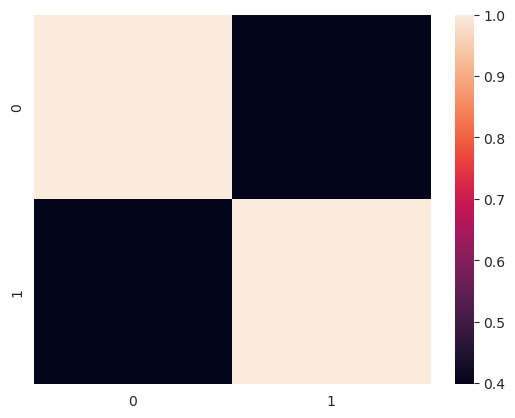

In [ ]:
#heatmap plots
sns.heatmap(train_gan[1].corr().values)

# n=10000
# sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
# mu_vec = np.array([0,0])
# dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
# sns.heatmap(dat)

plt.show()

## Real data in 2D

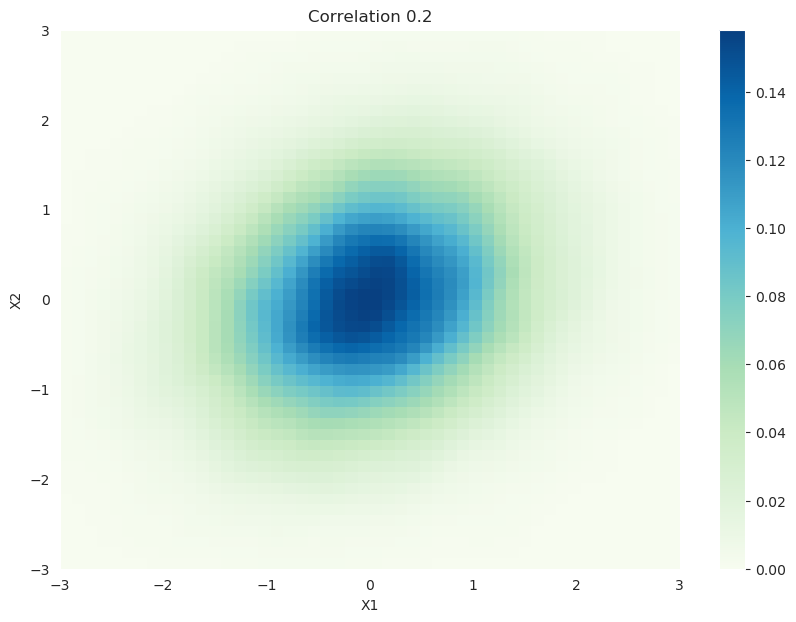

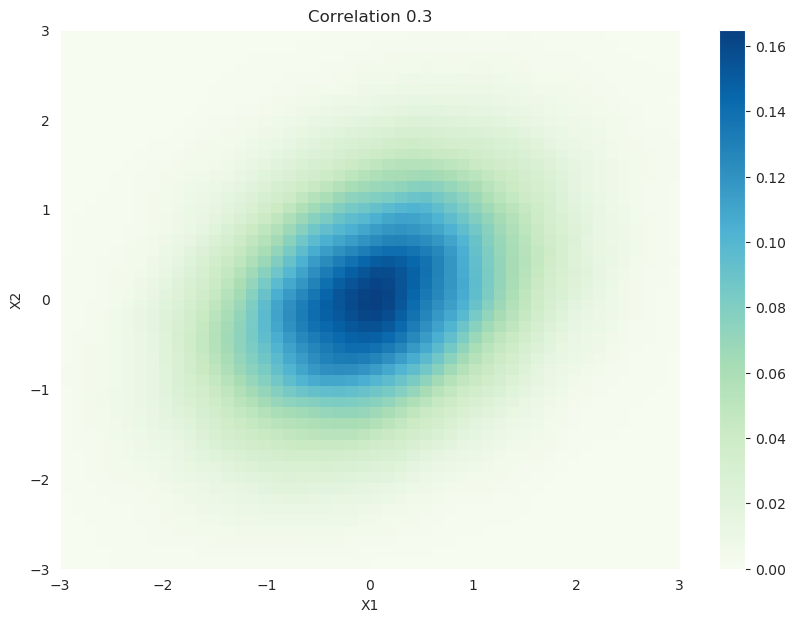

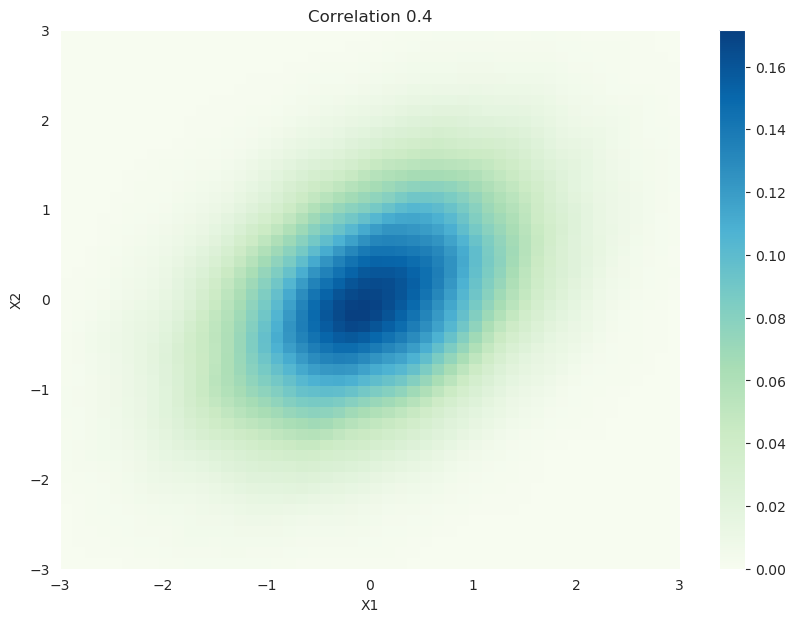

In [ ]:

for correlation in correlations:
    pop_n = 50_000
    pop_mu_vec = np.array([0.0,0.0])
    pop_sigma_matrix = np.array([[1.0 , correlation], [correlation, 1.0]])

    # load the dataset
    data = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)

    # extract the columns
    x1 = data[:,0]
    x2 = data[:,1]

    # create a scatter plot
    # plt.scatter(duration, waiting)
    # plt.xlim(0.5, 6)
    # plt.ylim(40, 100)

    # create a 2D kernel density estimate
    xmin, xmax, ymin, ymax = -3, 3, -3, 3
    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x1, x2])
    kernel = kde.gaussian_kde(values)
    f1 = np.reshape(kernel(positions).T, X.shape)

    # create an image plot of the density estimate
    plt.figure(figsize=(10,7))

    plt.imshow(f1, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', cmap='GnBu')
    plt.colorbar()
    plt.grid(None)

    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.title(f'Correlation {correlation}')

    plt.savefig(f'images/real-2d-cor-{correlation}.pdf', bbox_inches='tight')
    plt.show()

## Real data in 3D

In [ ]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting

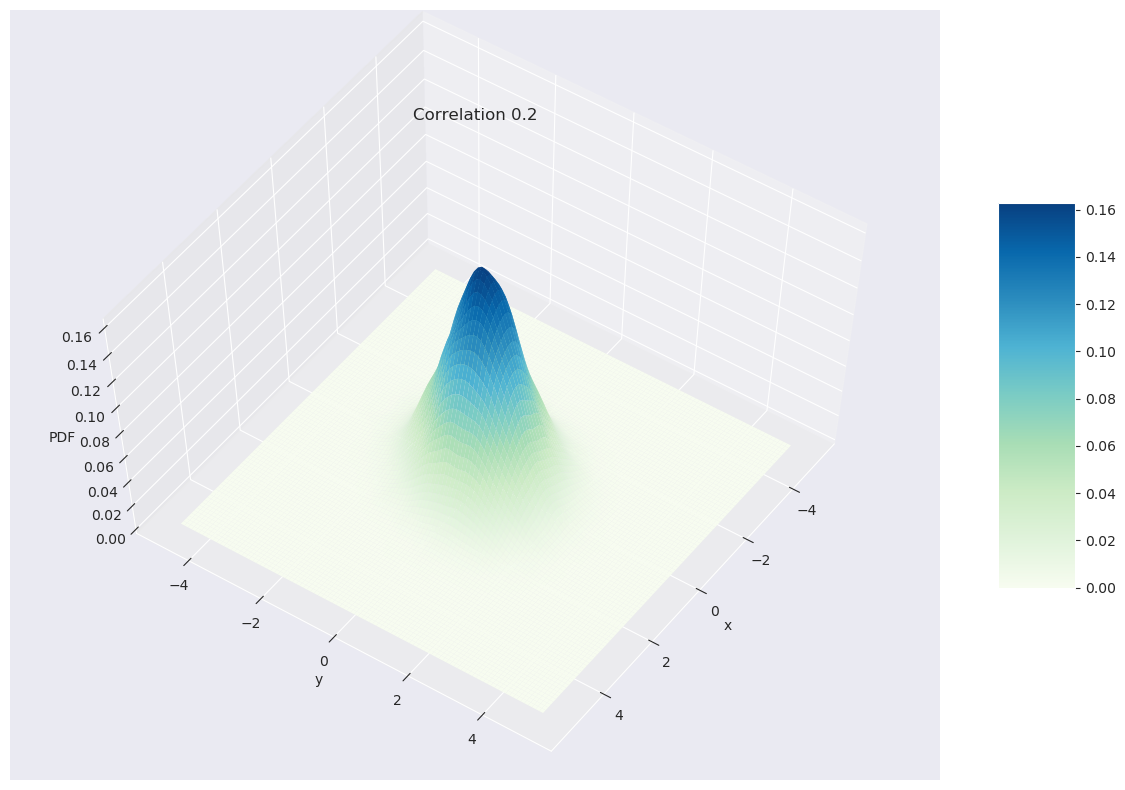

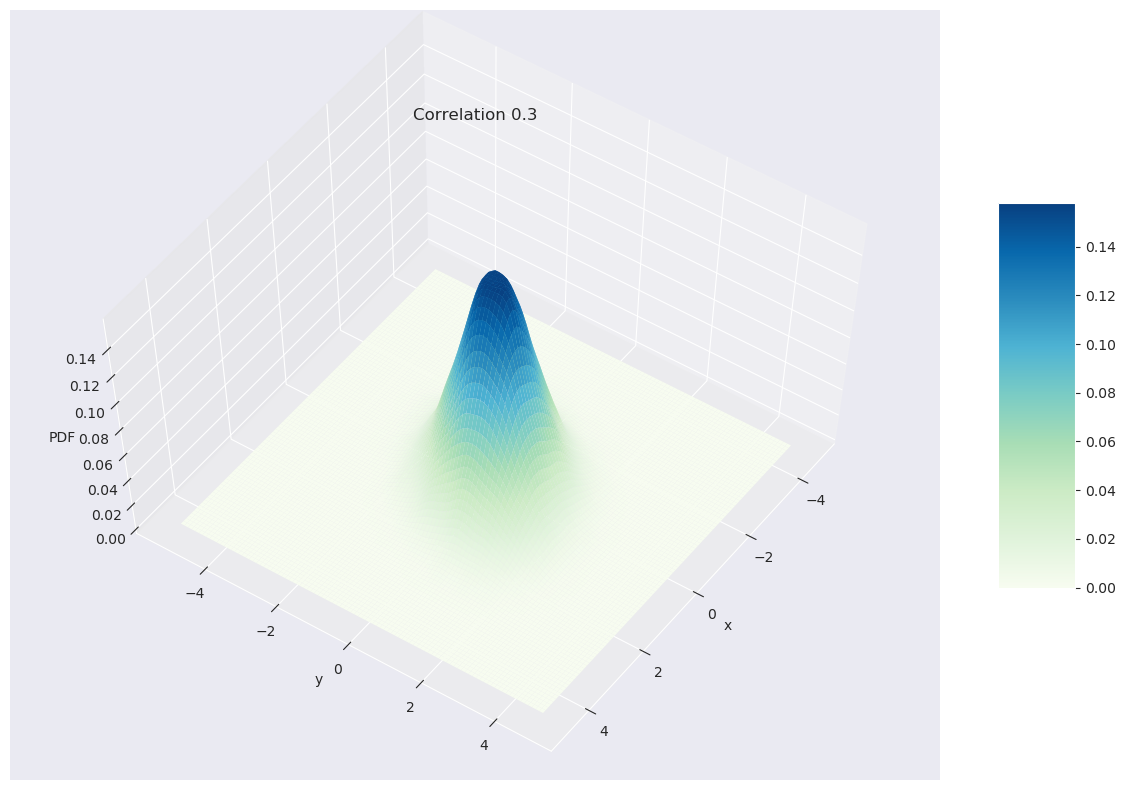

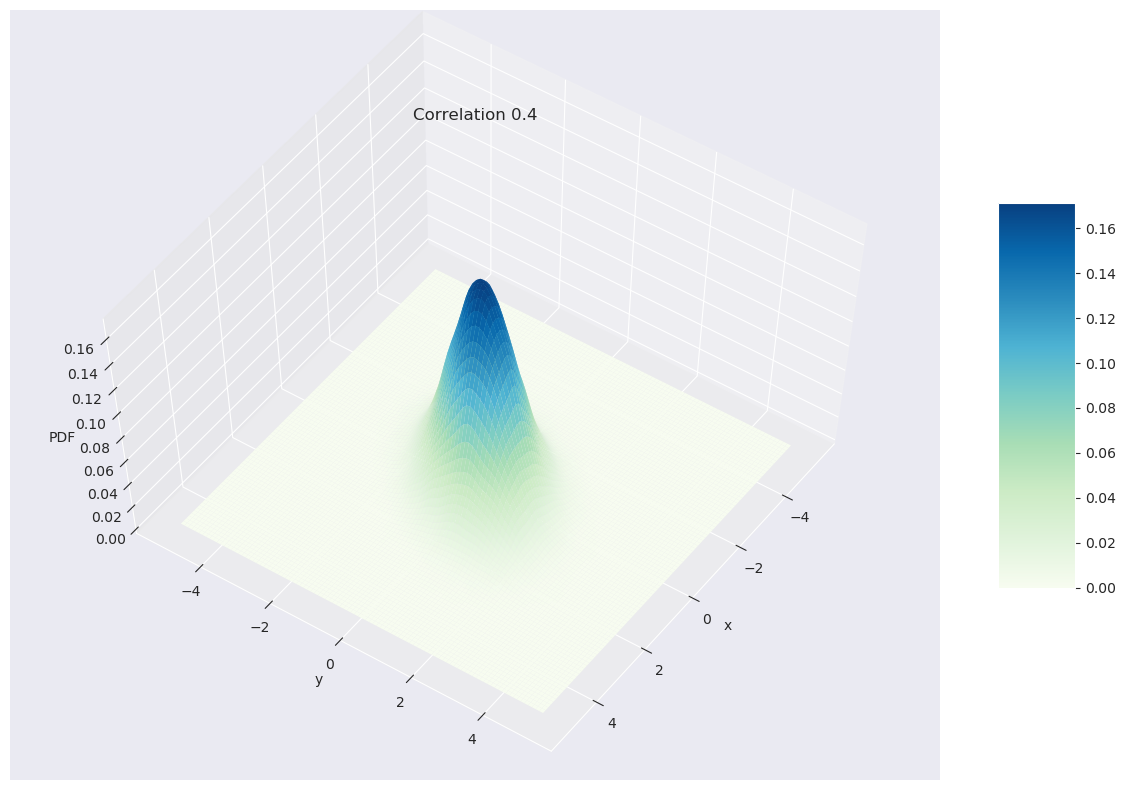

In [ ]:
for correlation in correlations:
    pop_n = 50_000
    pop_mu_vec = np.array([0.0,0.0])
    pop_sigma_matrix = np.array([[1.0 , correlation], [correlation, 1.0]])

    # load the dataset
    X = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)

    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]
    # Define the borders
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY
    print(xmin, xmax, ymin, ymax)
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='GnBu', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('PDF')
    ax.set_title('Surface plot of Gaussian 2D KDE')
    fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
    ax.view_init(60, 35)

    plt.title(f'Correlation {correlation}')
    plt.savefig(f'images/real-3d-cor-{correlation}.pdf', bbox_inches='tight')
    plt.show()

## GANs data in 2D

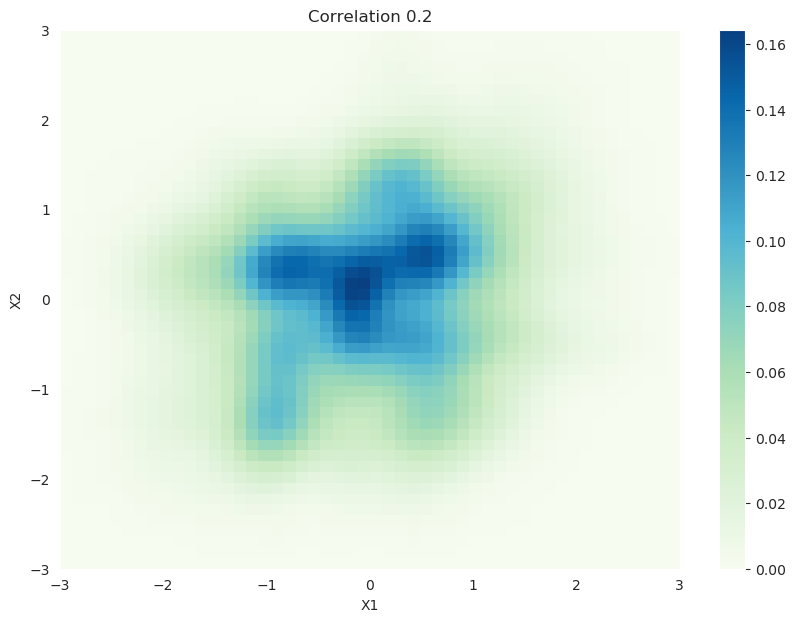

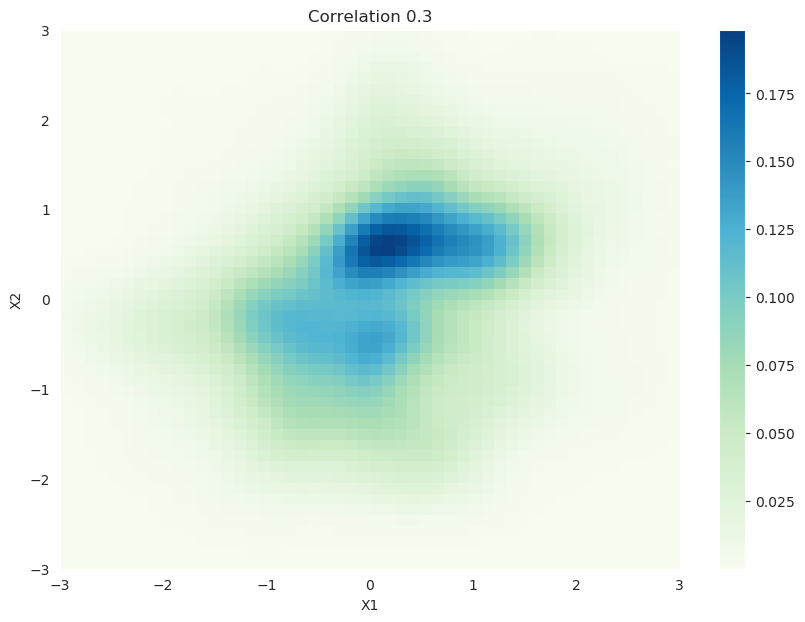

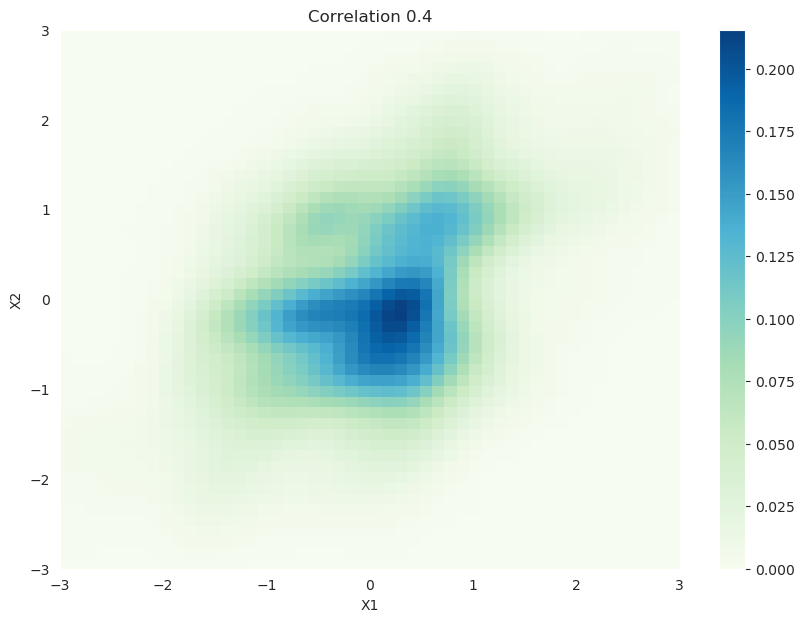

In [ ]:
for correlation in correlations:
    pop_n = 50_000

    # load the dataset
    data = models[correlation].sample(num_rows=pop_n).values

    # extract the columns
    x1 = data[:,0]
    x2 = data[:,1]

    # create a scatter plot
    # plt.scatter(duration, waiting)
    # plt.xlim(0.5, 6)
    # plt.ylim(40, 100)

    # create a 2D kernel density estimate
    xmin, xmax, ymin, ymax = -3, 3, -3, 3
    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x1, x2])
    kernel = kde.gaussian_kde(values)
    f1 = np.reshape(kernel(positions).T, X.shape)

    # create an image plot of the density estimate
    plt.figure(figsize=(10,7))

    plt.imshow(f1, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', cmap='GnBu')
    plt.colorbar()
    plt.grid(None)

    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.title(f'Correlation {correlation}')

    plt.savefig(f'images/gan-2d-cor-{correlation}.pdf', bbox_inches='tight')
    plt.show()

## GANs data in 3D

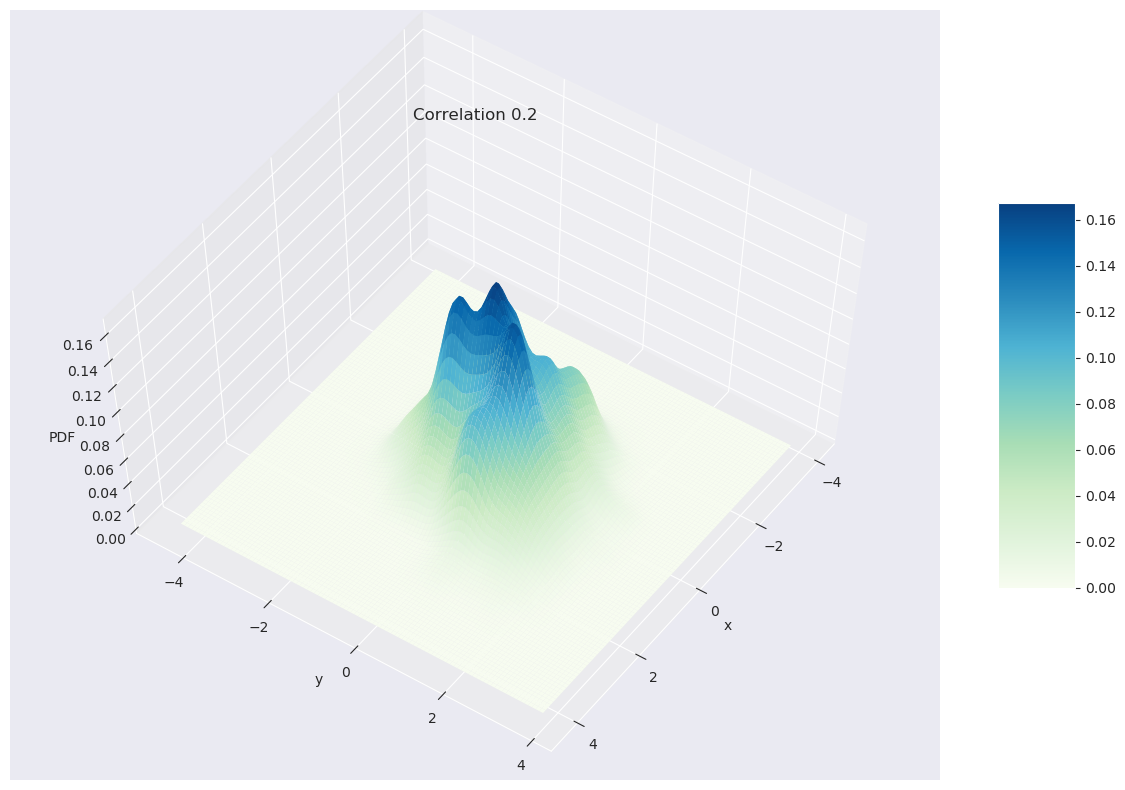

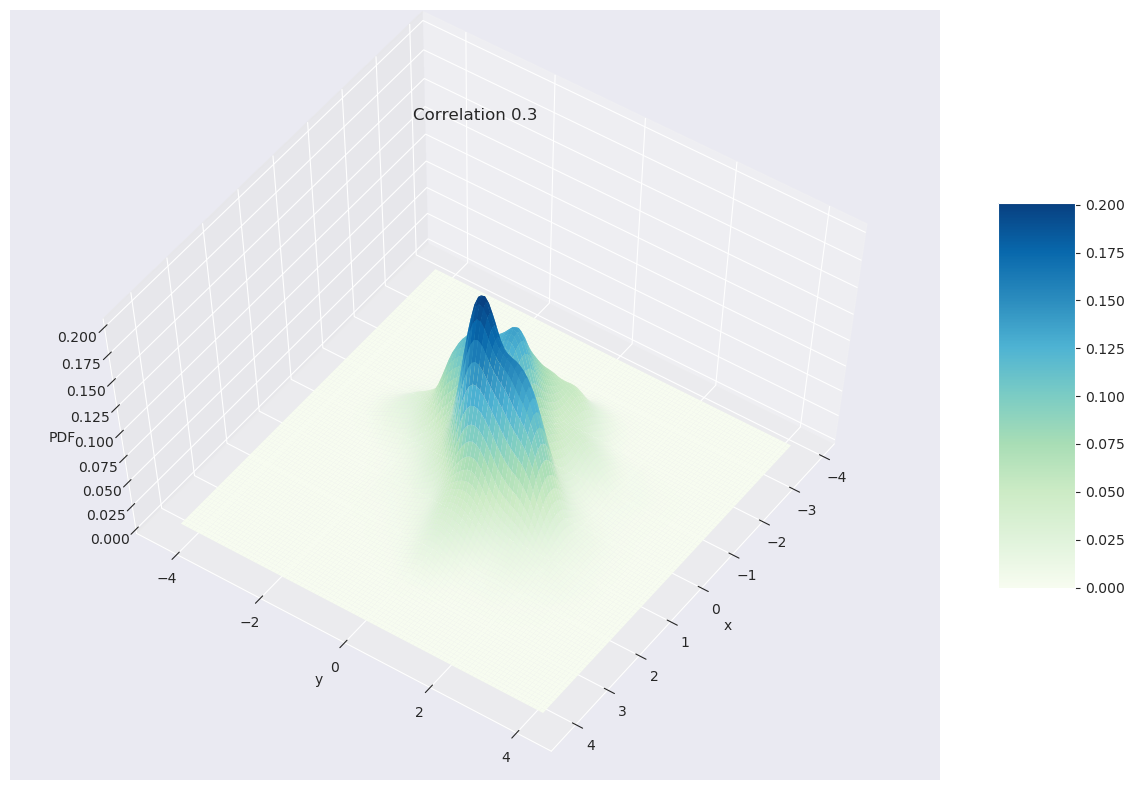

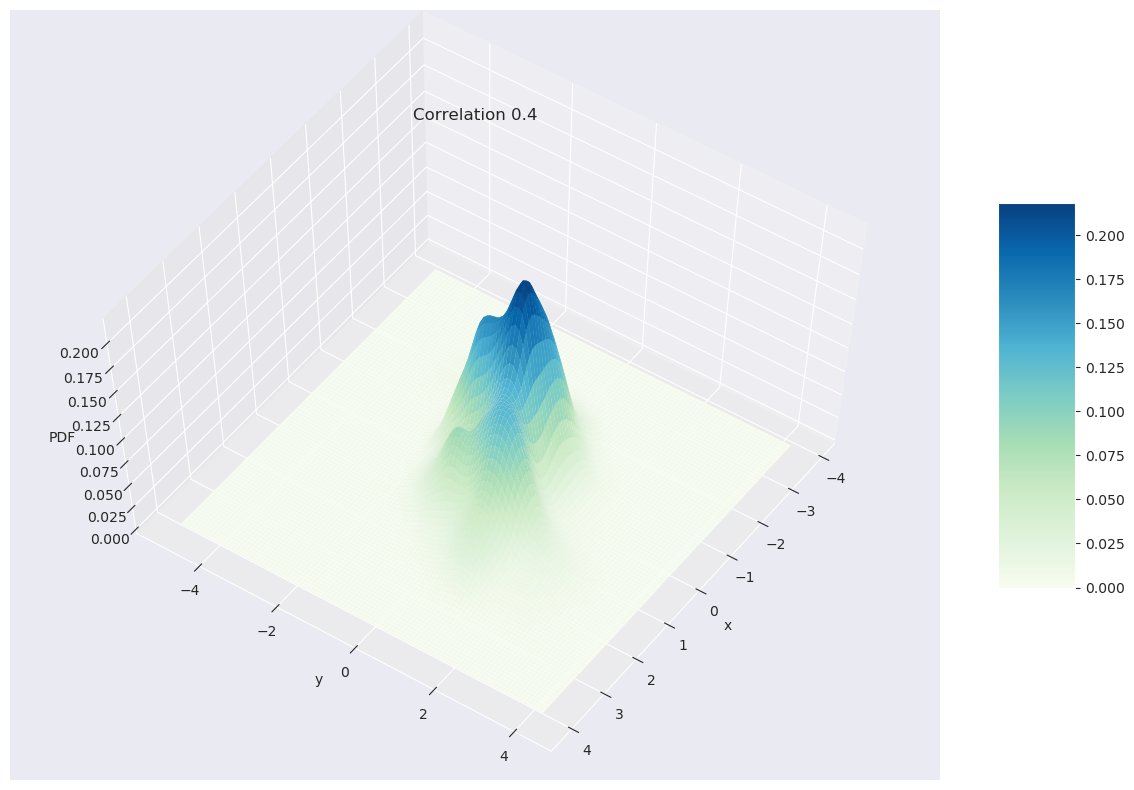

In [ ]:
for correlation in correlations:
    pop_n = 50_000
    pop_mu_vec = np.array([0.0,0.0])
    pop_sigma_matrix = np.array([[1.0 , correlation], [correlation, 1.0]])

    # load the dataset
    X = models[correlation].sample(num_rows=pop_n).values

    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]
    # Define the borders
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY
    print(xmin, xmax, ymin, ymax)
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='GnBu', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('PDF')
    ax.set_title('Surface plot of Gaussian 2D KDE')
    fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
    ax.view_init(60, 35)

    plt.title(f'Correlation {correlation}')

    plt.savefig(f'images/gan-3d-cor-{correlation}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
! zip -r images-correlation.zip images/